In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.stats import norm
import scipy.constants as scp
import scipy.integrate as integrate
from tabulate import tabulate
from scipy import signal
import scipy.constants as const

In [2]:
def sigma(x, y, dx, dy, label):
    s = np.abs(x-y)/np.sqrt(dx**2 + dy**2)
    print('Sigmaabweichung {} ='.format(str(label)), s)
    return s

---

# Nullmessung

In [3]:
U = 520
dU = 10
r = 0.007 #m
t_n0 = 5*60
N0 = 131

n0 = N0 /t_n0
dn0 = np.sqrt(N0)/t_n0
print(n0, dn0)

0.43666666666666665 0.038151743807531995


# Absorption von $\beta$-Strahlung in Aluminium

In [4]:
d3 = 6e-2 #m
dd = 0.3e-2
x3 = np.array([0,3,6,9,12,15,18,21,24,27,30,33,36,46])*0.1
t3 = np.array([30,30,30,30,30,120,120,120,120,120,120,120,120,300])
N3 = np.array([1075,670,371,318,198,517,309,194,132,76,62,56,54,133])

n3 = N3/t3
dn3 = np.sqrt(N3)/t3

n0b = n3[-1] # - n0
dn0b = np.sqrt(dn3[-1]**2)# + dn0**2)

diff = n3[:-1] - n0b
ddiff = np.sqrt((dn3[:-1])**2 + (dn0b)**2)

print(n3)
print(n0b, dn0b)
print(diff, ddiff)
len(diff)

[35.83333333 22.33333333 12.36666667 10.6         6.6         4.30833333
  2.575       1.61666667  1.1         0.63333333  0.51666667  0.46666667
  0.45        0.44333333]
0.44333333333333336 0.03844187531556932
[3.53900000e+01 2.18900000e+01 1.19233333e+01 1.01566667e+01
 6.15666667e+00 3.86500000e+00 2.13166667e+00 1.17333333e+00
 6.56666667e-01 1.90000000e-01 7.33333333e-02 2.33333333e-02
 6.66666667e-03] [1.09358229 0.86366789 0.64319515 0.59566023 0.47061426 0.19334052
 0.15144673 0.12227019 0.10317192 0.08219219 0.07604823 0.07325754
 0.07230337]


13

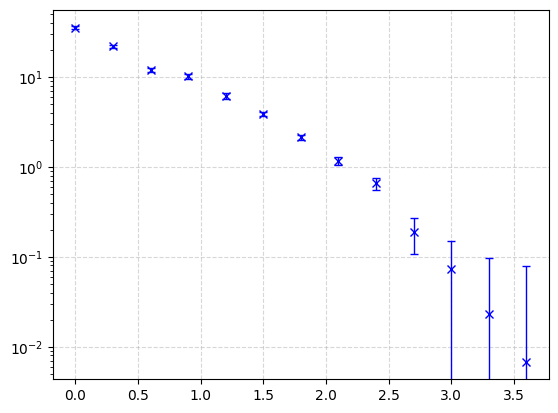

In [5]:
plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(x3[:-1], diff, yerr=ddiff, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)

plt.yscale('log')

In [6]:
def exp(x,b,c,d):
    return np.exp(-b*x + c) + d

In [7]:
popt3, pcov3 = curve_fit(exp, x3[:-1], diff, sigma=ddiff, absolute_sigma=True, p0=[1,3.5,-10])
popt3

array([ 1.48747317,  3.55512192, -0.27931199])

In [8]:
dpopt3 = np.sqrt(np.array([pcov3[0][0], pcov3[1][1], pcov3[2][2]]))

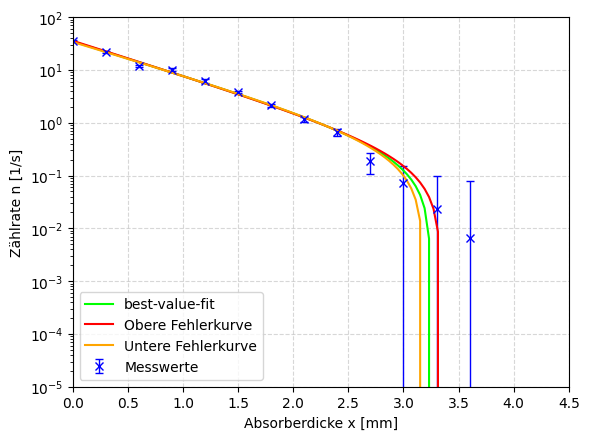

In [9]:
X = np.linspace(0, 4, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(x3[:-1], diff, yerr=ddiff, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)
plt.plot(X, exp(X, *popt3), color='lime', label='best-value-fit')
plt.plot(X, exp(X, *(popt3+dpopt3)), color='red', label='Obere Fehlerkurve')
plt.plot(X, exp(X, *(popt3-dpopt3)), color='orange', label='Untere Fehlerkurve')
plt.axis([0,4.5,1e-5,100])
plt.xlabel('Absorberdicke x [mm]')
plt.ylabel('Zählrate n [1/s]')
plt.legend(loc='lower left')

plt.yscale('log')

In [10]:
def SchnittpunktExp(popt, y):
    x = - (np.log(y - popt[2]) - popt[1])/popt[0]
    return x

In [11]:
x_max = SchnittpunktExp(popt3, 1e-5)
x_max_upper = SchnittpunktExp((popt3+dpopt3), 1e-5)
x_max_lower = SchnittpunktExp((popt3-dpopt3), 1e-5)

print('Maximale Absorptionsdicke = ({} + {} - {})mm'.format(x_max, np.abs(x_max_upper - x_max), np.abs(x_max_lower - x_max)))

Maximale Absorptionsdicke = (3.2474616043190485 + 0.09039971659687662 - 0.06809324586634657)mm


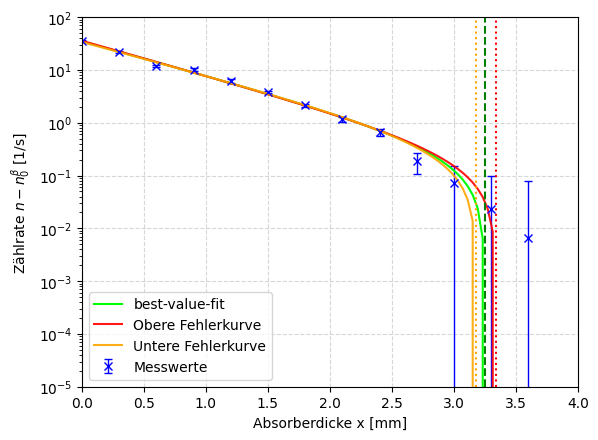

In [12]:
X = np.linspace(0, 4, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(x3[:-1], diff, yerr=ddiff, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)
plt.plot(X, exp(X, *popt3), color='lime', label='best-value-fit')
plt.plot(X, exp(X, *(popt3+dpopt3)), color='red', alpha=0.9, label='Obere Fehlerkurve')
plt.plot(X, exp(X, *(popt3-dpopt3)), color='orange', alpha=0.9, label='Untere Fehlerkurve')
plt.axis([0,4,1e-5,100])
plt.xlabel('Absorberdicke x [mm]')
plt.ylabel(r'Zählrate $n - n_0^\beta$ [1/s]')
plt.legend(loc='lower left')
plt.axvline(x_max, ls='--', color='green')
plt.axvline(x_max_upper, ls=':', color='red')
plt.axvline(x_max_lower, ls=':', color='orange')


plt.yscale('log')
plt.savefig('./plots/Maximalreichweite-beta.pdf', format='PDF')

In [13]:
rho_al = 2.71 #g/cm^3
R_ES = 0.130 #g/cm^2

Rbeta = rho_al * x_max/10 + R_ES
dRbeta_u = rho_al * np.abs(x_max_upper - x_max)/10
dRbeta_l = rho_al * np.abs(x_max_lower - x_max)/10

print('Flächendichte R_beta = ({} + {} - {})g/cm^3'.format(Rbeta, dRbeta_u, dRbeta_l))

Flächendichte R_beta = (1.0100620947704622 + 0.024498323197753562 - 0.018453269629779924)g/cm^3


In [14]:
# aus diagramm abgelesener Wert:
E_beta = 2.2
dE_beta = 0.1

#Literaturwert aus Abbildung 7:
E_b_lit = 2.274

_ = sigma(E_beta, E_b_lit, dE_beta, 0, 'Energie E_beta')

Sigmaabweichung Energie E_beta = 0.7399999999999984


# Absorption von $\gamma$-Strahlung in Blei

In [15]:
x4 = np.array([0,5,10,15,20,25,30,35,40,45,50]) *1e-1
t4 = 60 #s
N4 = np.array([1816,1221,911,664,532,394,290,212,144,141,117])

n4 = N4/t4
dn4 = np.sqrt(N4)/t4

diff4 = n4 - n0
ddiff4 = np.sqrt(dn4**2 + dn0**2)

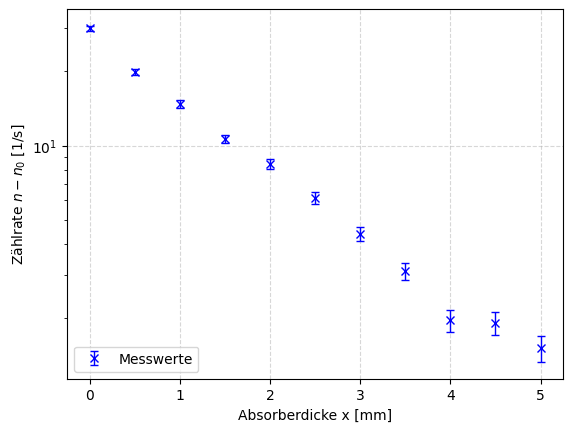

In [16]:
X = np.linspace(0, 5, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(x4, diff4, yerr=ddiff4, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)
#plt.axis([0,4,1e-5,100])
plt.xlabel('Absorberdicke x [mm]')
plt.ylabel(r'Zählrate $n - n_0$ [1/s]')
plt.legend(loc='lower left')


plt.yscale('log')

In [17]:
def Beere(x, n0, mu):
    return n0 * np.exp(-mu * x)

In [18]:
popt4, pcov4 = curve_fit(Beere, x4, diff4, sigma=ddiff4, absolute_sigma=True)

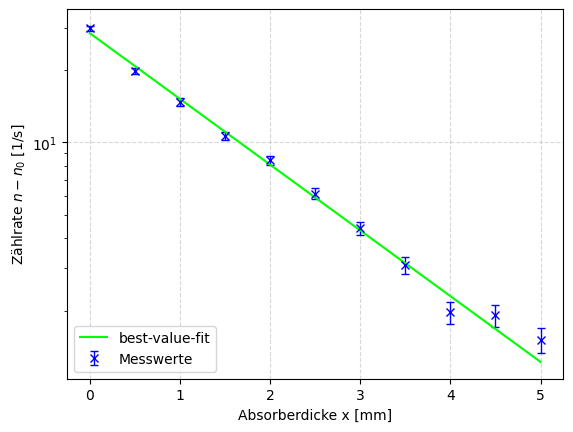

In [19]:
X = np.linspace(0, 5, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(x4, diff4, yerr=ddiff4, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)
#plt.axis([0,4,1e-5,100])
plt.plot(X, Beere(X, *popt4), color='lime', label='best-value-fit')
plt.xlabel('Absorberdicke x [mm]')
plt.ylabel(r'Zählrate $n - n_0$ [1/s]')
plt.legend(loc='lower left')


plt.yscale('log')
plt.savefig('./plots/Absorption-gamma.pdf', format='PDF')

In [20]:
rho_pb = 11.342 #g/cm^3 Wikipedia
mu4 = popt4[1]
dmu4 = np.sqrt(pcov4[1][1])

print(mu4, dmu4)

mu_rho = mu4/rho_pb
dmu_rho = dmu4/rho_pb

print('Massenschwächungskoeffizient = ({} +/- {})cm^2 /g'.format(mu_rho, dmu_rho))

0.629870854959079 0.011332162625019054
Massenschwächungskoeffizient = (0.05553437268198545 +/- 0.0009991326595855275)cm^2 /g


In [21]:
#Abgelesen Aus Diagramm 10:
E_gamma = 1.4 #MeV
dE_gamma = 0.2 #MeV

#Literaturwert Abb8:
E_gamma_lit = 1.333 #MeV

_ = sigma(E_gamma, E_gamma_lit, dE_gamma, 0, 'Energie E_gamma')

Sigmaabweichung Energie E_gamma = 0.33499999999999974


# Aktivität des $\gamma$-Strahlers

## Ohne Korrektur

In [22]:
d5 = np.array([5,10,20]) *1e-2 #m
dd = 0.3e-2
N5 = np.array([17662,6217,1522])
t5 = 60 #s

n5 = (N5/t5 - n0)/2
dn5 = np.sqrt((np.sqrt(N5)/t5/2)**2 + (dn0/2)**2)

print(n5)

[146.965  51.59   12.465]


In [23]:
epsilon = 0.04 #für gamma Strahlung
radius = 7e-3 #m

A = 4 * n5 * d5**2 /(epsilon * radius**2)
dA = A * np.sqrt((dd/d5)**2 + (dn5/n5)**2)

print(A)
print(dA)

[ 749821.42857143 1052857.14285714 1017551.02040816]
[45342.83654359 34316.52703128 30654.98882043]


In [24]:
#Literaturaktivität:
A_2021 = 1700e3
lamb = np.log(2)/(5.27*365*24*60*60) #halbwertszeit von 5,27 jahre
dT = 3.5 * 365 * 24 * 60 * 60 #Zeitdifferenz zum 01.01.2021 = genau 3,5 jahre

A_2024 = A_2021 * np.exp(-lamb * dT)

print(lamb)
print(A_2024)

4.170693151743601e-09
1072812.627745633


In [25]:
_ = sigma(A, A_2024, dA, 0, 'Aktivität ohne Korrektur')

Sigmaabweichung Aktivität ohne Korrektur = [7.12331261 0.58151237 1.8026954 ]


## Mit Korrektur

### Raumwinkelkorrektur

In [38]:
laenge = 4e-2 #m

#Korrekturfaktor:
k_corr = 4 * (d5 + laenge/2)**2 /(epsilon * radius**2)
dk_corr = dd * 2 * 4 * (d5 + laenge/2) /(epsilon * radius**2)

A_corr1 = n5 * k_corr
dA_corr1 = A_corr1 * np.sqrt((dk_corr/k_corr)**2 + (dn5/n5)**2)

print(A_corr1)
print(dA_corr1)


[1469650.         1516114.28571429 1231236.73469388]
[126456.04005609  78228.4170053   46500.8651679 ]


### Absorption der Präparatskapsel

In [39]:
dicke = 1.4e-1 *1e-3 #m
dichte = 7.9 #g/cm^3

#mit mu_rho aus aufgabe 4:
mu5 = mu_rho * dichte * 1e2 #1/m # = Schwächungskoeff.
dmu5 = dmu_rho * dichte * 1e2

print(mu5)
print(dmu5)

43.87215441876851
0.7893148010725668


In [40]:
A_corr2 = A_corr1 * np.exp(mu5 * dicke)
dA_corr2 = np.sqrt((dA_corr1 * np.exp(mu5 * dicke))**2 + 
                   (dicke * A_corr1 * np.exp(mu5 * dicke) * dmu5)**2)

print(A_corr2)
print(dA_corr2)

[1478704.51806341 1525455.07038151 1238822.38791377]
[127235.24102439  78710.56302391  46787.55740753]


In [41]:
_ = sigma(A_corr2, A_2024, dA_corr2, 0, 'Aktivität mit Korrektur')

Sigmaabweichung Aktivität mit Korrektur = [3.19009016 5.75072043 3.54816044]


# Absorption von $\alpha$-Strahlung

In [30]:
p6 = np.array([20,117,229,320,344,371,388,413,462,510,529,572,623,716])
N6 = np.array([12838,12959,12780,12460,11923,10971,9868,7573,2740,532,323,244,255,248])
t6 = 60 #s
d6 = 4.45 #cm
Arho6 = 2.35 #mg/cm^2

dN6 = np.sqrt(N6)

n6 = N6/t6
dn6 = dN6/t6

In [31]:
def sigmoid(x, L, x0, k, bkg):
    return L /(10+np.exp(-k*(x-x0))) +bkg

pop_sigm, cov_sigm = curve_fit(sigmoid, p6, n6, sigma=dn6, absolute_sigma=True, p0=[max(n6), np.median(p6), -1, min(n6)])

print(pop_sigm)
print(np.sqrt(cov_sigm.diagonal()))

[ 2.08133718e+03  3.62671385e+02 -3.84977231e-02  3.42203501e+00]
[9.20881305e+00 1.14341542e+00 4.93563329e-04 1.50843185e-01]


C:\Users\matth\AppData\Local\Temp\ipykernel_12964\4164407031.py:2: RuntimeWarning: overflow encountered in exp
  return L /(10+np.exp(-k*(x-x0))) +bkg


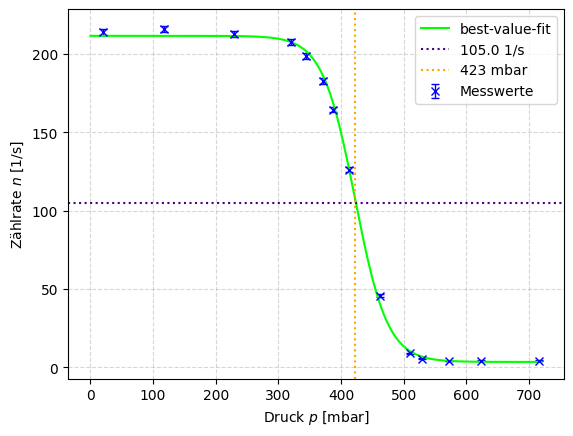

In [32]:
#%matplotlib ipympl
#abgelesen aus plot:
p_half = 423 #mbar
dp_half = 3 #mbar



X = np.linspace(0, 720, 1000)

plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(p6, n6, yerr=dn6, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)
plt.plot(X, sigmoid(X, *pop_sigm), color='lime', label='best-value-fit')
plt.axhline((n6[0]-n6[-1])/2, color='indigo', ls=':', label='{} 1/s'.format(np.round((n6[0]-n6[-1])/2),1))
plt.axvline(p_half, color='orange', ls=':', label='423 mbar')
plt.xlabel('Druck $p$ [mbar]')
plt.ylabel(r'Zählrate $n$ [1/s]')
plt.legend()
plt.savefig('./plots/Aktivität-alpha.pdf', format='PDF')

In [33]:
s0 = 3.95 #cm
ds0 = 0.05 #cm

p0 = 1013 #mbar

s1 = p_half/p0 * s0
ds1 = s1 * np.sqrt((ds0/s0)**2 + (dp_half/p_half)**2)

print('s1 = ({} +/- {})cm'.format(s1, ds1))

s1 = (1.6494076999012834 +/- 0.0239323324031545)cm


In [34]:
rho_glimm = 1.43 #mg/cm^3

s2 = Arho6/rho_glimm *1

print('s2 = ', s2, 'cm')

s2 =  1.6433566433566436 cm


In [35]:
s3 = 0.68 #cm

print('s3 = ', s3, 'cm')

s3 =  0.68 cm


In [36]:
s_ges = s1 + s2 + s3
ds_ges = ds1

print('s_ges = ({} +/- {})cm'.format(s_ges, ds_ges))

s_ges = (3.972764343257927 +/- 0.0239323324031545)cm


In [37]:
#aus diagramm 9:
E_alpha = 5.5 #MeV
dE_alpha = 0.3 #MeV

E_alpha_lit = 5.48

_ = sigma(E_alpha, E_alpha_lit, dE_alpha, 0, 'Energie alpha Strahlung')

Sigmaabweichung Energie alpha Strahlung = 0.06666666666666525
